# 2D Airfoil shape optimization via Reinforcement Learning

In this example we will show the steps to train an agent that optimizes airfoils. We will reproduce some of the results of [https://arxiv.org/abs/2505.02634](https://arxiv.org/abs/2505.02634)   

First, we will start by importing the necessary functions and classes and defining the operating conditions

## Define operating conditions

In [1]:
from pyLOM.RL import (
    create_env,
    AirfoilOperatingConditions,
    AirfoilCSTParametrizer,
    AirfoilParameterizerConfig,
    NeuralFoilSolver,
)
from stable_baselines3 import PPO
import gymnasium as gym

import torch

# neuralfoil should be faster with single thread
torch.set_num_threads(1)

0 Warning! Import - NVTX not present!


In [2]:
operating_conditions = AirfoilOperatingConditions(
    alpha=4.0,
    mach=0.2,
    Reynolds=1e6,
)

## Shape parameterization and design space

Now we need to define the design space where the agent is going to be trained on. We use a CST parameterization, so the bounds for the upper and lower surfaces, leading-edge weight and trailing-edge thickness need to be defined. We can instantiate directly an `AirfoilCSTParametrizer`

In [3]:
leading_edge_weight_min, leading_edge_weight_max = -0.05, 0.75
TE_thickness_min, TE_thickness_max = 0.0005, 0.01
upper_edge_min, upper_edge_max = -1.5, 1.25
lower_edge_min, lower_edge_max = -0.75, 1.5
n_weights_per_side = 8

parameterizer = AirfoilCSTParametrizer(
    upper_surface_bounds=(
        [upper_edge_min] * n_weights_per_side,
        [upper_edge_max] * n_weights_per_side,
    ),
    lower_surface_bounds=(
        [lower_edge_min] * n_weights_per_side,
        [lower_edge_max] * n_weights_per_side,
    ),
    TE_thickness_bounds=(
        TE_thickness_min,
        TE_thickness_max,
    ),
    leading_edge_weight=(
        leading_edge_weight_min,
        leading_edge_weight_max,
    ),
)

As it can be seen, the airfoils will be defined by 18 parameters. We can use an `AirfoilParameterizerConfig` to create a parameterizer too

In [4]:
parameterizer = AirfoilParameterizerConfig().create_parameterizer()

If no parameters are passed, it will create a parameterizer with default params, which are exactly the same as the ones defined on the previous cell.

## Define the solver

Now we need to create a solver that will give us the lift-to-drag ratio of a given airfoil, for this example, we will use NeuralFoil as it quite faster than XFoil. Here, we need to specify the operating conditions, that have been defined before.

In [5]:
solver = NeuralFoilSolver(
    alpha=operating_conditions.alpha,
    Reynolds=operating_conditions.Reynolds,
)

## Create the environment

Now we have everything we need to create an environment. We will set the maximum length of an episode to 64.

Note: if you have been following the [paper](https://arxiv.org/abs/2505.02634), there is a term $\sigma$ that penalizes changes on the maximum thickness. If this term wants to be added to the environment, you can use the parameter `thickness_penalization_factor` when creating the environment. For the example, we will leave that to 0, its defaul value.

In [7]:
env = gym.make(
    "ShapeOptimizationEnv-v0",
    solver=solver,
    parameterizer=parameterizer,
    episode_max_length=64,
)

Great, now we've leared to create an enviroment, but you can do all of this in just one line, using the built-in function on pyLOM, `create_env`. This function takes different parameters that gives the option to customize the environment. Additionally, with this funcion you can create parallel environment to speed up the training usign the parameter `num_envs`.

The only required parameter is the `solver_name`, the rest od them have a default value.

In [ ]:
env = create_env(
    "neuralfoil", operating_conditions=operating_conditions, episode_max_length=64
)


You can see the internal state of the environment calling the `render` method

(None, Airfoil Untitled (Kulfan / CST parameterization))

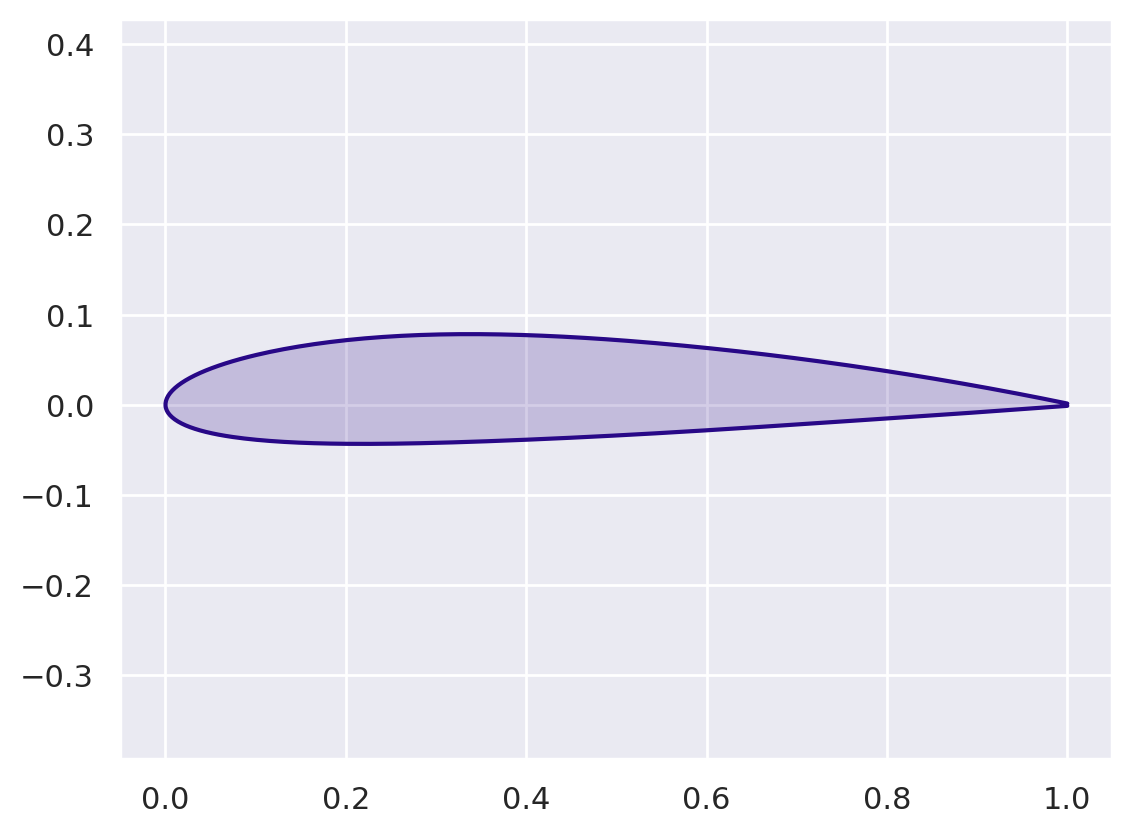

In [9]:
env.reset()
env.render()

## Define the PPO agent and train it on the environment

We define the same hyperparameters used to train an agent with neuralfoil on the previously mentioned paper. An important note here is that if you want to use parallel environment you should divide the value of the parameter `n_steps` by the number of environments used.

In [10]:
ppo_parameters = {
    "learning_rate": 2.5e-4,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.3,
    "ent_coef": 0, 
    "clip_range": 0.6,
    "verbose": 1,
    "device": "cpu",
    "policy_kwargs": {"net_arch": dict(pi=[256, 256], vf=[256, 256])},
}

training_timesteps = 25000

model = PPO("MlpPolicy", env, **ppo_parameters)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=training_timesteps)
model.save("airfoil_agent")

If you want to use a model that is already trained you can load it

In [11]:
model = PPO.load("airfoil_agent")

## Test the agent

Now we have a trained agent, we play with it. pyLOM has its own methods to make the evaluations and to plot the optimization process of an airfoil

In [12]:
from pyLOM.RL import (
    evaluate_airfoil_agent,
    run_episode,
    create_airfoil_optimization_progress_plot,
)
import aerosandbox as asb

In [13]:
airfoil_to_optimize = "naca0012"
airfoil = asb.Airfoil(airfoil_to_optimize)
rewards, states = run_episode(model, env, initial_shape=airfoil)

Now we can create a plot showing the optimization process using the function `create_airfoil_optimization_progress_plot`. However, that function expects as its first parameter a list of `asb.Airfoil` and the function `run_episode` returns `states` which is a list of vectors from the design space, so we need to create the airfoils. Fortunately, the parameterizer we created before can do exactly that, the next cell converts the vectors to actual Airfoils

In [14]:
airfoils = list(map(lambda x: parameterizer.get_shape_from_params(x), states))

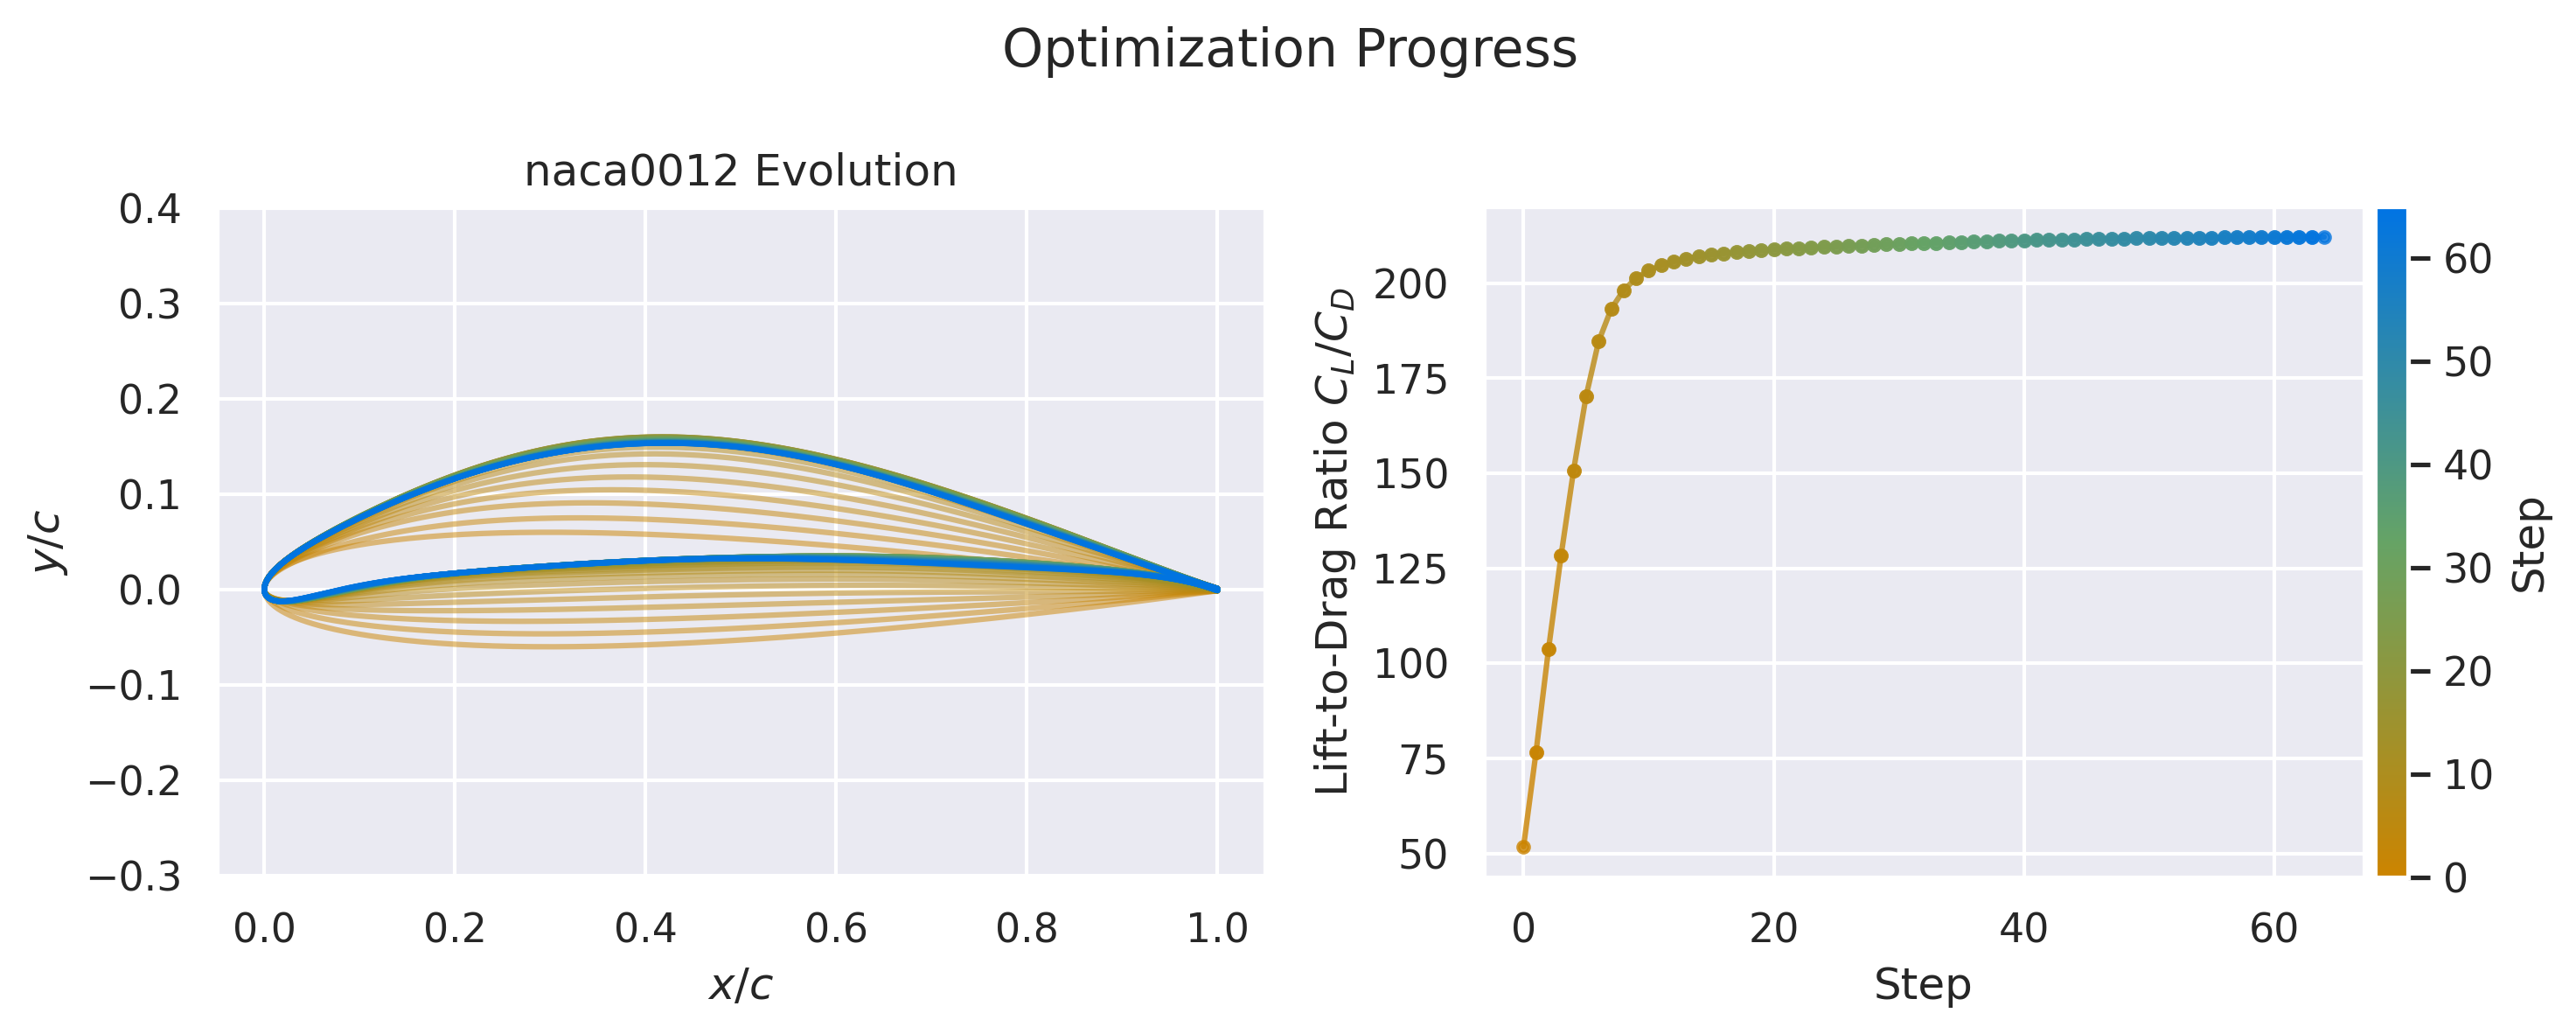

In [15]:
create_airfoil_optimization_progress_plot(
    airfoils, rewards, airfoil_name=airfoil_to_optimize
)


You can create an animation of the optimization process too, but for that you will need to install manim with `conda install -c conda-forge manim`.   
If the video generationit takes too long you can adjust the quality changing the "-qp" option:  
* -ql: for low quality
* -qm: for medium quality
* -qh: for high quality 
* -qp: for production quality (the highest)

In [16]:
import manim
from pyLOM.RL import AirfoilEvolutionAnimation

In [ ]:
%%manim -qp -v WARNING AirfoilEvolutionAnimation 


AirfoilEvolutionAnimation.airfoils = airfoils
AirfoilEvolutionAnimation.rewards = rewards
AirfoilEvolutionAnimation.title = f"{airfoil_to_optimize.capitalize()} Evolution"

This is a small trick to actually show the resulting video on the documentation, the code here is not relevant since the previous cell must have already shown it

In [17]:
import base64
from IPython.display import HTML
video_path = "./media/videos/notebook_examples/1440p60/_AirfoilEvolutionAnimation.mp4"

with open(video_path, "rb") as f:
    video_data = base64.b64encode(f.read()).decode()

HTML(f"""
<video width="800" controls>
    <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
    Your browser does not support the video tag.
</video>
""")

## Evaluate the agent

Now, time to evaluate and get some metrics. First we need to run a bunch of episodes and compute the improvement that the agent obtains. The function `evaluate_airfoil_agent` will evaluate an agent with a random subset of the UIUC dataset. The size of that subset is defined with the parameter `num_episodes`. If you want to store the results on a csv file, you just need to set a path for the parameter `save_results_path`.

In [18]:
rewards, states = evaluate_airfoil_agent(model, env, num_episodes=100)

Evaluating airfoils:   0%|          | 0/100 [00:00<?, ?airfoil/s]

Evaluating airfoils: 100%|██████████| 100/100 [00:58<00:00,  1.70airfoil/s]

Number of airfoils converged: 100
Best CL/CD (median(IQR)): 202 (7)
Best CL/CD increment (mean +/- std): 118.1+/-23.9


One aspect to note here, is that the evaluation is performed by NeuralFoil, since the envionment uses NeuralFoil as solver. If you want to evaluate an agent with XFoil, you just need to pass to `evaluate_airfoil_agent` an environment that uses XFoil as sovler.

Other important aspect is the execution time. This can be accelerated with MPI, and the function `pyLOM.RL.evaluate_airfoil_agent_whole_uiuc_mpi` can do that. You can see a complete example in pyLOM/Examples/RL/eval_agent_mpi.py

# Using the agent on realistic scenarios

Now is time to use the agent to optimize a given airfoil as if it were a real situation. First, let's load the airfoil to be optimized

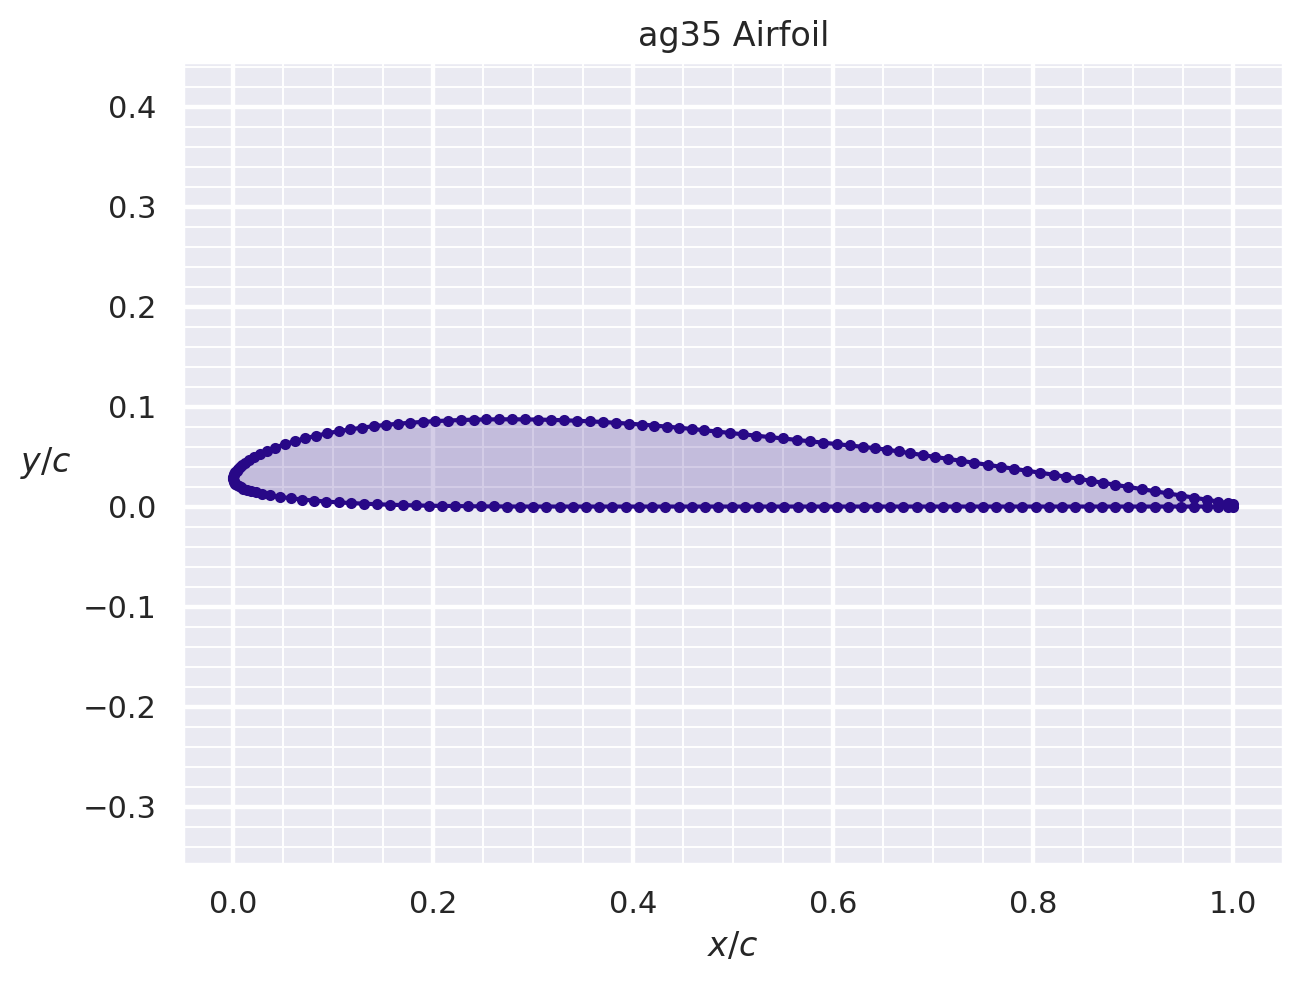

In [19]:
airfoil_to_optimize = asb.Airfoil("ag35")
airfoil_to_optimize.draw(backend="matplotlib")

One of the strengths of this method compared with other traditional mehtods for optimization is that once trained, the optimization time becomes negligible. To this end, now a new environment is created that has a "dummy" solver. This solver always returns 0, so we won't get the lift-to-drag ratio

In [21]:
env = create_env("dummy")

In [22]:
%%time
rewards, states = run_episode(model, env, initial_shape=airfoil_to_optimize)

CPU times: user 80.2 ms, sys: 46 μs, total: 80.2 ms
Wall time: 78.5 ms


This shows the real potential of RL, once an agent is trained, an airofil can be optimize in around 0.1 seconds. The only difference here is that the lift-to-drag ratio is not computed, but if you want to do it, you would only have to use an environment with another solver. 

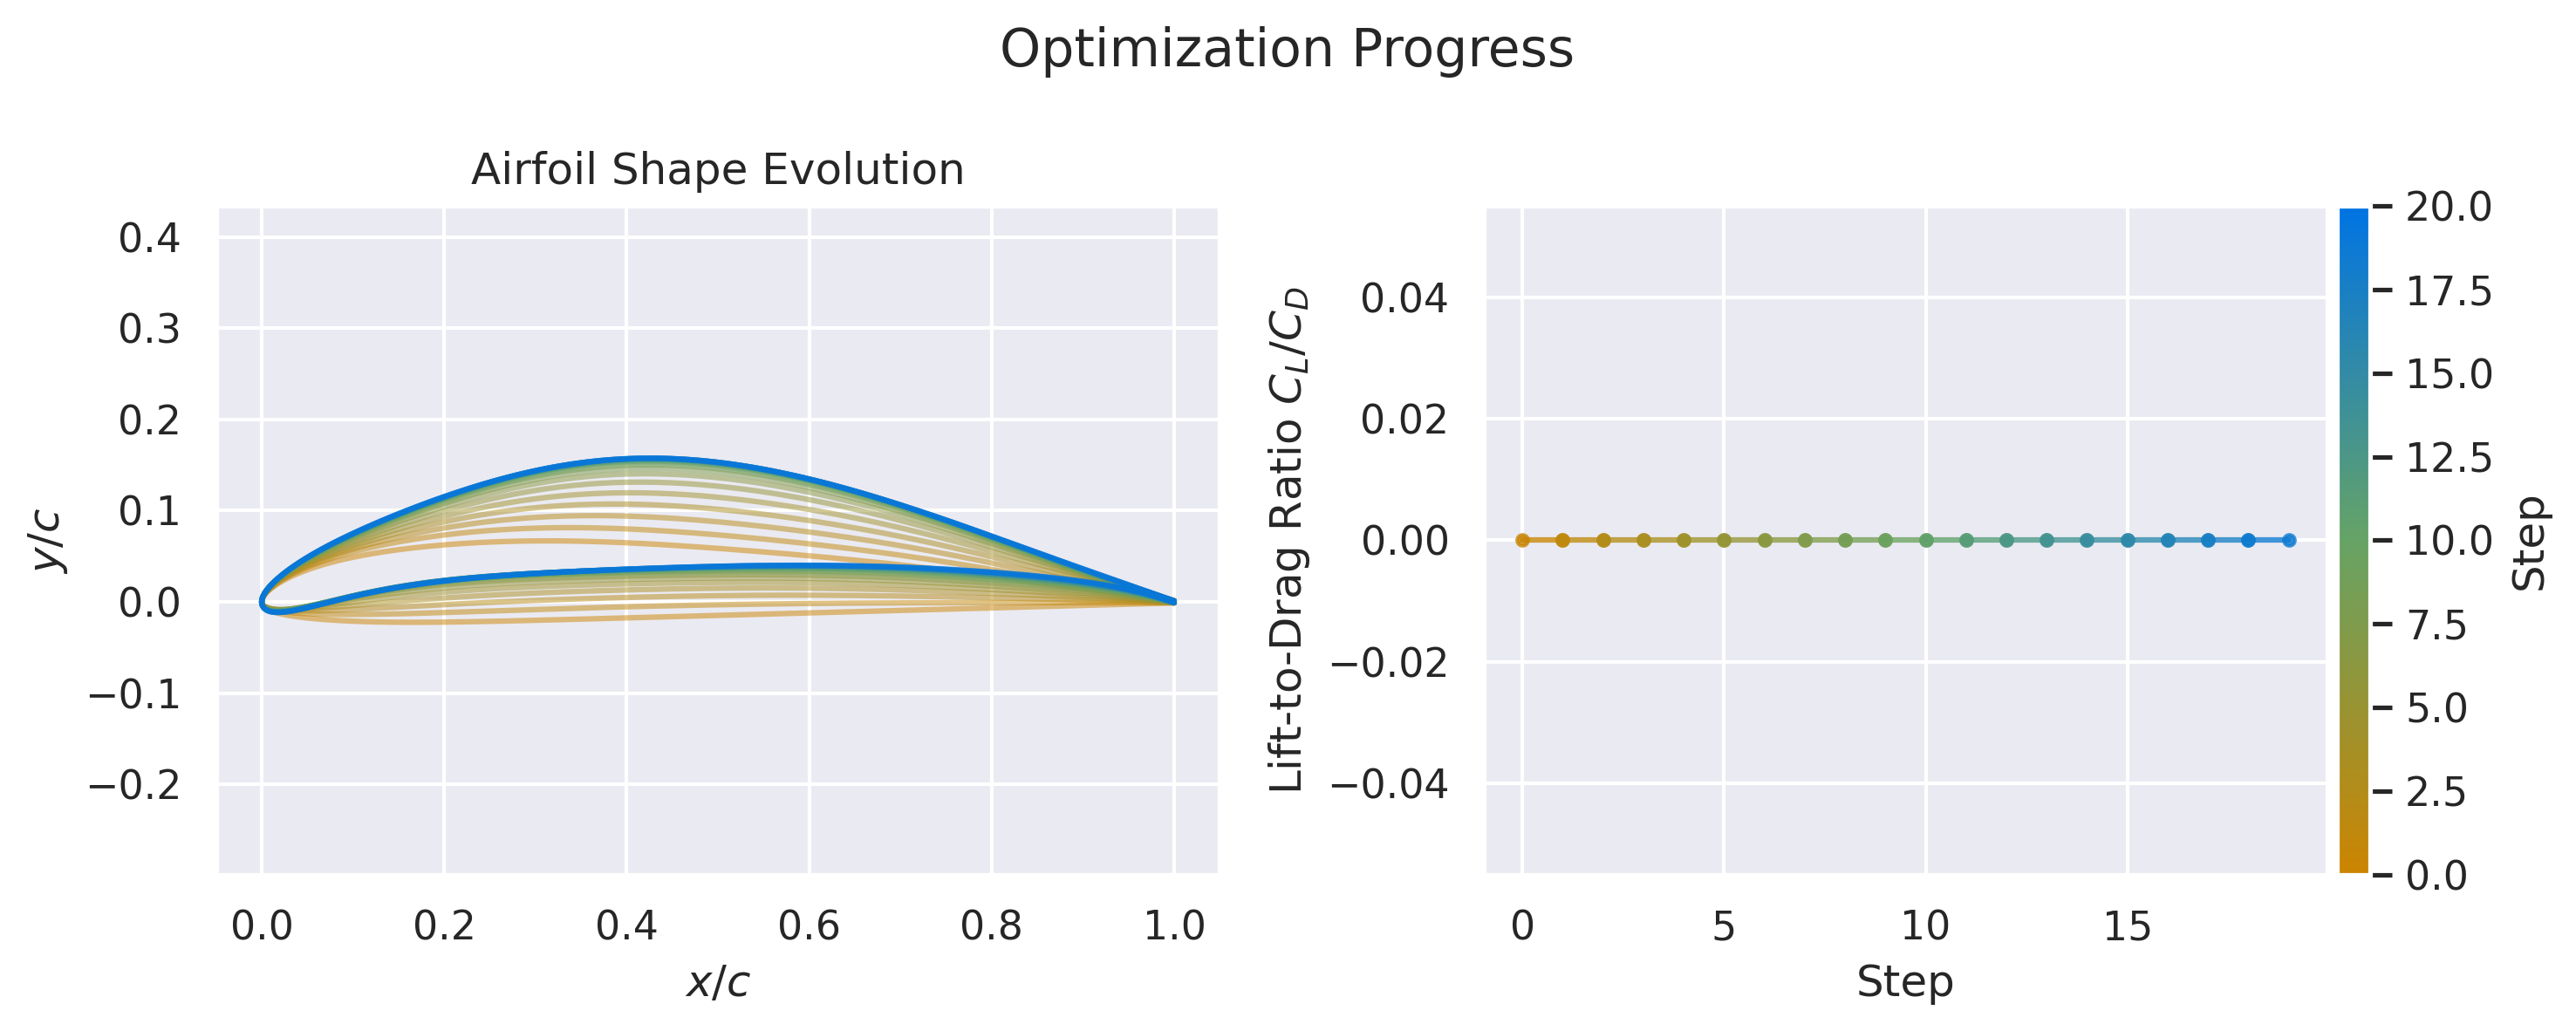

In [23]:
airfoils = list(map(lambda x: parameterizer.get_shape_from_params(x), states))
create_airfoil_optimization_progress_plot(airfoils[:20], rewards[:20])

Any intermediate state of the optimization process can be plotted and saved into a .dat file with the airfoil coordinates

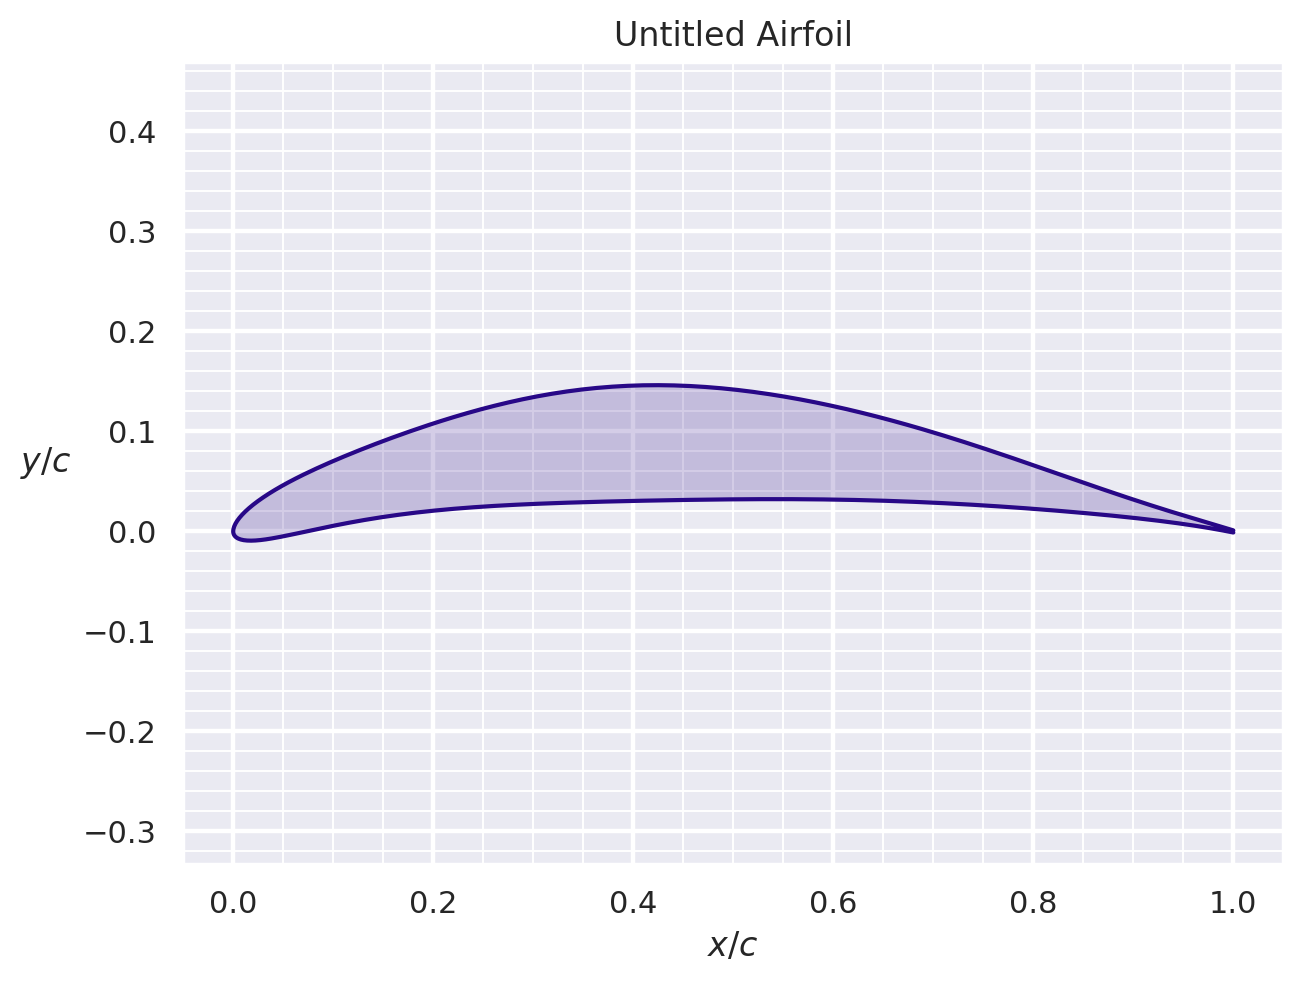

In [24]:
airfoils[7].draw()

In [ ]:
airfoils[7].write_dat("airfoil_optimized.dat")